In [21]:
import pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("Stock Price Predictor").getOrCreate()

In [29]:
data = spark.read.csv('stock_data', header = True)

In [30]:
data.show(10)

+------+----------+----------+-------+--------+--------+--------+
|Ticker|      Date|Close/Last| Volume|    Open|    High|     Low|
+------+----------+----------+-------+--------+--------+--------+
| BRK-B|05/31/2023|  $321.08 |6175417|$321.12 |$322.41 |$319.39 |
| BRK-B|05/30/2023|  $322.19 |3232461|$321.86 |$322.47 |$319.00 |
| BRK-B|05/26/2023|  $320.60 |3229873|$320.44 |$322.63 |$319.67 |
| BRK-B|05/25/2023|  $319.02 |4251935|$320.56 |$320.56 |$317.71 |
| BRK-B|05/24/2023|  $320.20 |3075393|$322.71 |$323.00 |$319.56 |
| BRK-B|05/23/2023|  $323.11 |4031342|$328.19 |$329.27 |$322.97 |
| BRK-B|05/22/2023|  $329.13 |2763422|$330.75 |$331.49 |$328.35 |
| BRK-B|05/19/2023|  $330.39 |4323538|$331.00 |$333.94 |$329.12 |
| BRK-B|05/18/2023|  $329.76 |2808329|$326.87 |$329.98 |$325.85 |
| BRK-B|05/17/2023|  $327.39 |3047626|$325.02 |$328.26 |$324.82 |
+------+----------+----------+-------+--------+--------+--------+
only showing top 10 rows



In [4]:
# now let us scale the data , so that it is easier to train our model later

In [39]:
# scaling
data_scale = data.select("Close/Last", "Volume", "Open", "High", "Low")
from pyspark.ml.feature import VectorAssembler, StandardScaler

features_to_scale = ['Close/Last', 'Volume', 'Open', 'High', 'Low']
# first let us drop any na values
data_scale = data_scale.na.drop()

# now lets assemble these features into a single vector column
assembler = VectorAssembler(inputCols = features_to_scale, outputCol = "features")
data_scale = assembler.transform(data_scale)

# now we can scale these assembled features
scaler = StandardScaler(inputCol = "features", outputCol = "scaledFeatures", withStd = True, withMean = False)
scaler_model = scaler.fit(data_scale)
data_scaled = scaler_model.transform(data_scale)

IllegalArgumentException: Data type string of column Close/Last is not supported.
Data type string of column Volume is not supported.
Data type string of column Open is not supported.
Data type string of column High is not supported.
Data type string of column Low is not supported.

In [34]:
from pyspark.sql.functions import col
from pyspark.sql.types import DoubleType

# List of column names to convert
columns_to_convert = ["Close/Last", "Volume", "Open", "High", "Low"]

# Loop over the columns and apply the type conversion
for column in columns_to_convert:
    data_scale = data_scale.withColumn(column, col(column).cast(DoubleType()))


In [35]:
data_scale.show(5)

+----------+---------+----+----+----+
|Close/Last|   Volume|Open|High| Low|
+----------+---------+----+----+----+
|      NULL|6175417.0|NULL|NULL|NULL|
|      NULL|3232461.0|NULL|NULL|NULL|
|      NULL|3229873.0|NULL|NULL|NULL|
|      NULL|4251935.0|NULL|NULL|NULL|
|      NULL|3075393.0|NULL|NULL|NULL|
+----------+---------+----+----+----+
only showing top 5 rows



In [8]:
# this happened because our close/last, open, high and low column contained a $ sign. hence it was unable to convert
# it to double. so let us remove the $ sign first before converting the data type to double

In [40]:
from pyspark.sql.functions import col, expr

# List of column names to convert
columns_to_convert = ["Close/Last", "Volume", "Open", "High", "Low"]

# Loop over the columns and apply the type conversion
for column in columns_to_convert:
    data_scale = data_scale.withColumn(column, expr(f"regexp_replace(`{column}`, '[$,]', '')").cast(DoubleType()))



In [41]:
data_scale.show(10)

+----------+---------+------+------+------+
|Close/Last|   Volume|  Open|  High|   Low|
+----------+---------+------+------+------+
|    321.08|6175417.0|321.12|322.41|319.39|
|    322.19|3232461.0|321.86|322.47| 319.0|
|     320.6|3229873.0|320.44|322.63|319.67|
|    319.02|4251935.0|320.56|320.56|317.71|
|     320.2|3075393.0|322.71| 323.0|319.56|
|    323.11|4031342.0|328.19|329.27|322.97|
|    329.13|2763422.0|330.75|331.49|328.35|
|    330.39|4323538.0| 331.0|333.94|329.12|
|    329.76|2808329.0|326.87|329.98|325.85|
|    327.39|3047626.0|325.02|328.26|324.82|
+----------+---------+------+------+------+
only showing top 10 rows



In [11]:
# perfect, now all our data is converted to double, so we can proceed to scaling it

In [42]:
# scaling
from pyspark.ml.feature import VectorAssembler, StandardScaler

features_to_scale = ['Close/Last', 'Volume', 'Open', 'High', 'Low']

# now lets assemble these features into a single vector column
assembler = VectorAssembler(inputCols = features_to_scale, outputCol = "features")
data_scale = assembler.transform(data_scale)

# now we can scale these assembled features
scaler = StandardScaler(inputCol = "features", outputCol = "scaledFeatures", withStd = True, withMean = False)
scaler_model = scaler.fit(data_scale)
data_scaled = scaler_model.transform(data_scale)

In [43]:
data_scaled.show(10)

+----------+---------+------+------+------+--------------------+--------------------+
|Close/Last|   Volume|  Open|  High|   Low|            features|      scaledFeatures|
+----------+---------+------+------+------+--------------------+--------------------+
|    321.08|6175417.0|321.12|322.41|319.39|[321.08,6175417.0...|[3.17432956425283...|
|    322.19|3232461.0|321.86|322.47| 319.0|[322.19,3232461.0...|[3.18530348295322...|
|     320.6|3229873.0|320.44|322.63|319.67|[320.6,3229873.0,...|[3.16958408589591...|
|    319.02|4251935.0|320.56|320.56|317.71|[319.02,4251935.0...|[3.15396355297103...|
|     320.2|3075393.0|322.71| 323.0|319.56|[320.2,3075393.0,...|[3.16562952059847...|
|    323.11|4031342.0|328.19|329.27|322.97|[323.11,4031342.0...|[3.19439898313733...|
|    329.13|2763422.0|330.75|331.49|328.35|[329.13,2763422.0...|[3.25391519086375...|
|    330.39|4323538.0| 331.0|333.94|329.12|[330.39,4323538.0...|[3.26637207155068...|
|    329.76|2808329.0|326.87|329.98|325.85|[329.76,280

In [47]:
# so now , two new columns have been created, one with features that contains the combined data
# and one with scaledFeatures which contains the scaled data
from pyspark.ml import Pipeline
from pyspark.ml.regression import GBTRegressor
from pyspark.ml.evaluation import RegressionEvaluator 
import matplotlib.pyplot as plt

Root Mean Squared Error (RMSE) on test data = 31.866402197309235
MAE: 16.775946672158817
R2: 0.9339171630503069


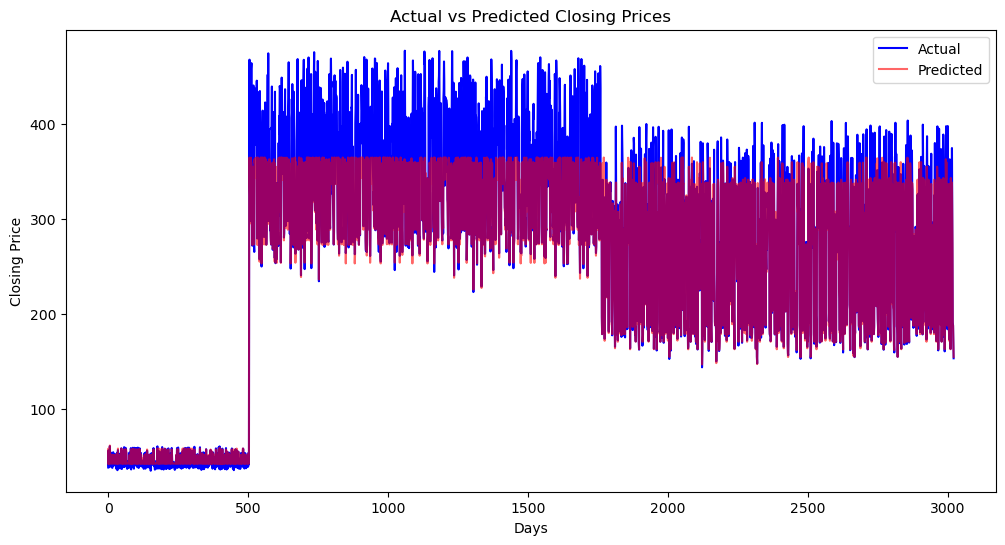

In [49]:
# Split the data into a training set and a test set. 
# Here, we're using a time-based split - 80% for training and 20% for testing
train_count = int(data_scaled.count() * 0.8)
train_data = data_scaled.limit(train_count)
test_data = data_scaled.subtract(train_data)

# Model Training
# Gradient Boosted Trees are chosen due to their robustness and ability to model non-linear patterns
gbt = GBTRegressor(labelCol="Close/Last", featuresCol="scaledFeatures", maxIter=50)
model = gbt.fit(train_data)
predictions = model.transform(test_data)

# Model Evaluation
# Compute the RMSE (Root Mean Squared Error) for the predictions
evaluator_rmse = RegressionEvaluator(labelCol="Close/Last", predictionCol="prediction", metricName="rmse")
rmse = evaluator_rmse.evaluate(predictions)
print("Root Mean Squared Error (RMSE) on test data =", rmse)

# Compute other metrics: Mean Absolute Error (MAE) and R-squared (R2)
for metric in ["mae", "r2"]:
    evaluator = RegressionEvaluator(labelCol="Close/Last", predictionCol="prediction", metricName=metric)
    value = evaluator.evaluate(predictions)
    print(f"{metric.upper()}: {value}")

# Visualization
# Plot the actual vs predicted values for adjusted closing prices
preds = predictions.select("Close/Last", "prediction").toPandas()
plt.figure(figsize=(12, 6))
plt.plot(preds["Close/Last"], label='Actual', color='blue')
plt.plot(preds["prediction"], label='Predicted', color='red', alpha=0.6)
plt.title('Actual vs Predicted Closing Prices')
plt.xlabel('Days')
plt.ylabel('Closing Price')
plt.legend()
plt.show()

# Terminate the Spark session
#spark.stop()

In [66]:
predictions.show()

+----------+----------+-----+-----+-----+--------------------+--------------------+------------------+
|Close/Last|    Volume| Open| High|  Low|            features|      scaledFeatures|        prediction|
+----------+----------+-----+-----+-----+--------------------+--------------------+------------------+
|     37.79| 6047147.0|37.71|37.92| 37.5|[37.79,6047147.0,...|[0.37360755647537...| 41.95420362327161|
|      55.8|1.029569E7|55.08|56.04|55.06|[55.8,1.029569E7,...|[0.55166185899248...| 57.75071827883069|
|      43.7| 8112550.0|43.52| 44.0|43.46|[43.7,8112550.0,4...|[0.43203625874501...| 41.95420362327161|
|     38.09| 6256453.0|37.91|38.28|37.87|[38.09,6256453.0,...|[0.37657348044845...| 41.95420362327161|
|     40.68| 4125085.0| 41.3|41.35|40.68|[40.68,4125085.0,...|[0.40217929074936...|42.146585940646936|
|     39.54| 6154841.0| 39.7|39.86| 39.4|[39.54,6154841.0,...|[0.39090877965166...| 41.95420362327161|
|     60.32| 6719190.0|60.16|60.64|59.92|[60.32,6719190.0,...|[0.59634844

In [ ]:
# now lets plot separately for each stock

In [62]:
data_scaled.show(5)

+----------+---------+------+------+------+--------------------+--------------------+
|Close/Last|   Volume|  Open|  High|   Low|            features|      scaledFeatures|
+----------+---------+------+------+------+--------------------+--------------------+
|    321.08|6175417.0|321.12|322.41|319.39|[321.08,6175417.0...|[3.17432956425283...|
|    322.19|3232461.0|321.86|322.47| 319.0|[322.19,3232461.0...|[3.18530348295322...|
|     320.6|3229873.0|320.44|322.63|319.67|[320.6,3229873.0,...|[3.16958408589591...|
|    319.02|4251935.0|320.56|320.56|317.71|[319.02,4251935.0...|[3.15396355297103...|
|     320.2|3075393.0|322.71| 323.0|319.56|[320.2,3075393.0,...|[3.16562952059847...|
+----------+---------+------+------+------+--------------------+--------------------+
only showing top 5 rows



In [61]:
data.filter(data.Ticker == "MSFT").count()

1259

In [64]:
data.filter(data.Ticker == "BRK-B").count()

1259

In [68]:
# example for BRK-B, 
data_scaled_ = data_scaled.limit(1259)

Root Mean Squared Error (RMSE) on test data = 1.4602763713695688
MAE: 1.1140731779794115
R2: 0.9716104521795984


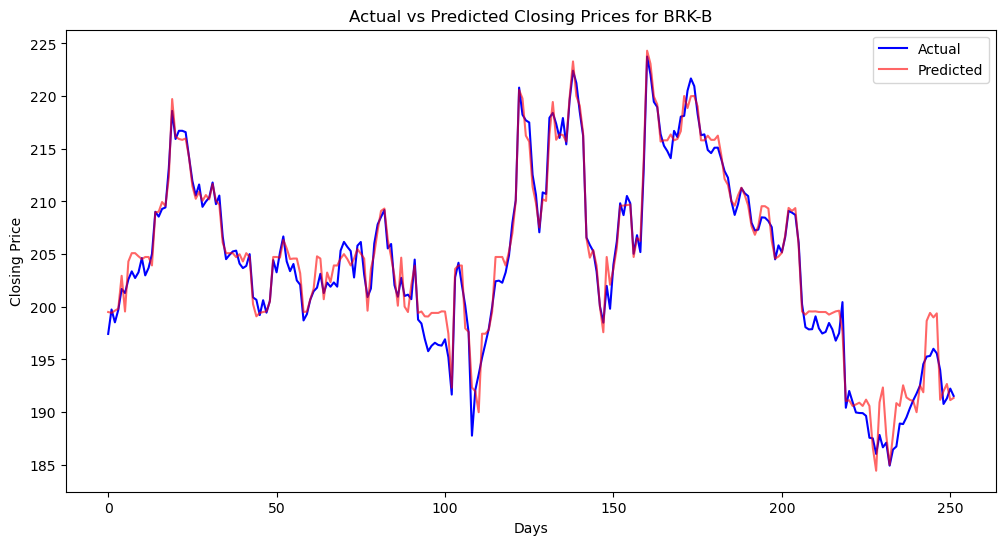

In [70]:
# Split the data into a training set and a test set. 
# Here, we're using a time-based split - 80% for training and 20% for testing
train_count = int(data_scaled_.count() * 0.8)
train_data = data_scaled_.limit(train_count)
test_data = data_scaled_.subtract(train_data)

# Model Training
# Gradient Boosted Trees are chosen due to their robustness and ability to model non-linear patterns
gbt = GBTRegressor(labelCol="Close/Last", featuresCol="scaledFeatures", maxIter=50)
model = gbt.fit(train_data)
predictions = model.transform(test_data)

# Model Evaluation
# Compute the RMSE (Root Mean Squared Error) for the predictions
evaluator_rmse = RegressionEvaluator(labelCol="Close/Last", predictionCol="prediction", metricName="rmse")
rmse = evaluator_rmse.evaluate(predictions)
print("Root Mean Squared Error (RMSE) on test data =", rmse)

# Compute other metrics: Mean Absolute Error (MAE) and R-squared (R2)
for metric in ["mae", "r2"]:
    evaluator = RegressionEvaluator(labelCol="Close/Last", predictionCol="prediction", metricName=metric)
    value = evaluator.evaluate(predictions)
    print(f"{metric.upper()}: {value}")

# Visualization
# Plot the actual vs predicted values for adjusted closing prices
preds = predictions.select("Close/Last", "prediction").toPandas()
plt.figure(figsize=(12, 6))
plt.plot(preds["Close/Last"], label='Actual', color='blue')
plt.plot(preds["prediction"], label='Predicted', color='red', alpha=0.6)
plt.title('Actual vs Predicted Closing Prices for BRK-B')
plt.xlabel('Days')
plt.ylabel('Closing Price')
plt.legend()
plt.show()

# Terminate the Spark session
#spark.stop()